# Installing the required libraries
- You will be prompted to restart the runtime

In [ ]:
!pip install pyyaml==5.1

     |████████████████████████████████| 274 kB 7.9 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=4ba6b4acdbffd57e725822384c886bc5ca699e50c3a352708c1f2e915a89970e
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 735.4 MB 16 kB/s 
     |████████████████████████████████| 12.8 MB 33.8 MB/s 
     |████████████████████████████████| 7.6 MB 5.5 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.10.0+cu111
    Uninstalling torchaudio-0.10.0+cu111:
      Successfully uninstalled torchaudio-0.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch

In [ ]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

1.7.1+cu101
True


In [ ]:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
     |████████████████████████████████| 6.1 MB 11.6 MB/s 
     |████████████████████████████████| 49 kB 4.1 MB/s 
     |████████████████████████████████| 130 kB 16.1 MB/s 
     |████████████████████████████████| 145 kB 53.1 MB/s 
     |████████████████████████████████| 74 kB 3.7 MB/s 
     |████████████████████████████████| 843 kB 58.1 MB/s 
     |████████████████████████████████| 748 kB 58.5 MB/s 
     |████████████████████████████████| 112 kB 49.7 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20220212-py3-none-any.whl size=61216 sha256=b6da45ca6e658904f96820f7768f815e24745b83a6758dbc40d9c9ab9d4e7522
  Stored in directory: /root/.cache/pip/wheels/92/43/75/238d2a5d897274799f92b8938f3cd807a3ccd3c8f37c0a4725
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141230 sha256=f46e4c670bbd62613d9ab12049443867dbab561848ba6f13e2d84cdc5842d

# Importing colab-specific stuff

In [ ]:
from detectron2.utils.logger import setup_logger
setup_logger()
from google.colab.patches import cv2_imshow

# Modifying the KITTI dataset and registering it
The KITTI dataset is not officially recognized by detectron2 as a function, so we will: 
- modify it into a format similar to the COCO dataset (which is recognized and understood by detectron2)
- register it (make detectron2 recognize it as a dataset)

## Modifying functions

In [ ]:
import os
import cv2
from glob import glob

from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode
from pycocotools import coco
import numpy as np

In [ ]:
kitti_correspondences = {
    'Car': 0,
    'Pedestrian': 1,
}

mots_correspondences = {
    'Pedestrian': 1
}

In [ ]:
def get_kiti_mots_dicts(images_folder, annots_folder, is_train, train_percentage=0.75, image_extension="jpg"):
    assert os.path.exists(images_folder)
    assert os.path.exists(annots_folder)

    annot_files = sorted(glob(os.path.join(annots_folder, "*.txt")))

    n_train_seqences = int(len(annot_files) * train_percentage)
    train_sequences = annot_files[:n_train_seqences]
    test_sequences = annot_files[n_train_seqences:]

    sequences = train_sequences if is_train else test_sequences

    kitti_mots_annotations = []
    for seq_file in sequences:
        seq_images_path = os.path.join(images_folder, seq_file.split("/")[-1].split(".")[0])
        kitti_mots_annotations += mots_annots_to_coco(seq_images_path, seq_file, image_extension)

    return kitti_mots_annotations


def mots_annots_to_coco(images_path, txt_file, image_extension):
    assert os.path.exists(txt_file)

    # chapuza guapisima pero paso de refactorizar el codigo
    if "Challenge" in images_path:
        correspondences = mots_correspondences
    else:
        correspondences = kitti_correspondences
        
    print(txt_file)

    n_seq = int(txt_file.split("/")[-1].split(".")[0])

    mots_annots = []
    with open(txt_file, 'r') as f:
        annots = f.readlines()
        annots = [l.split() for l in annots]

        annots = np.array(annots)

        for frame in np.unique(annots[:, 0].astype('int')):

            frame_lines = annots[annots[:, 0] == str(frame)]
            if frame_lines.size > 0:

                h, w = int(frame_lines[0][3]), int(frame_lines[0][4])

                f_objs = []
                for a in frame_lines:
                    cat_id = int(a[2]) - 1
                    if cat_id in correspondences.values() or ("Challenge" in images_path and cat_id == 1):
                        segm = {
                            "counts": a[-1].strip().encode(encoding='UTF-8'),
                            "size": [h, w]
                        }

                        box = coco.maskUtils.toBbox(segm)
                        box[2:] = box[2:] + box[:2]
                        box = box.tolist()

                        # mask to poly
                        mask = np.ascontiguousarray(coco.maskUtils.decode(segm))
                        contours, _ = cv2.findContours(mask.astype("uint8"), cv2.RETR_TREE,
                                                        cv2.CHAIN_APPROX_SIMPLE)
                        poly = []

                        for contour in contours:
                            contour = contour.flatten().tolist()
                            if len(contour) > 4:
                                poly.append(contour)
                        if len(poly) == 0:
                            continue

                        annot = {
                            "category_id": 0 if "Challenge" in images_path else cat_id,
                            "bbox_mode": BoxMode.XYXY_ABS,
                            "bbox": box,
                            "segmentation": poly

                        }
                        f_objs.append(annot)


                frame_data = {
                    "file_name": os.path.join(images_path, '{:06d}.{}'.format(int(a[0]), image_extension)),
                    "image_id": int(frame + n_seq * 1e6),
                    "height": h,
                    "width": w,
                    "annotations": f_objs
                }
                mots_annots.append(frame_data)

    return mots_annots

## Registering function


In [ ]:
def register_kitti_mots_dataset(ims_path, annots_path, dataset_names, train_percent=0.75, image_extension='jpg'):
    assert isinstance(dataset_names, tuple), "dataset names should be a tuple with two strings (for train and test) "

    def kitti_mots_train(): return get_kiti_mots_dicts(ims_path, annots_path, is_train=True,
                                                       train_percentage=train_percent, image_extension=image_extension)

    def kitti_mots_test(): return get_kiti_mots_dicts(ims_path, annots_path, is_train=False,
                                                      train_percentage=train_percent, image_extension=image_extension)

    DatasetCatalog.register(dataset_names[0], kitti_mots_train)
    MetadataCatalog.get(dataset_names[0]).set(thing_classes=[k for k, v in kitti_correspondences.items()])
    DatasetCatalog.register(dataset_names[1], kitti_mots_test)
    MetadataCatalog.get(dataset_names[1]).set(thing_classes=[k for k, v in kitti_correspondences.items()])

## Using the above functions

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
register_kitti_mots_dataset("/content/drive/MyDrive/KITTI MOTS/training/image_02",
                            "/content/drive/MyDrive/KITTI MOTS/training/instances_txt",
                            ("kitti_mots_train", "kitti_mots_test"),
                            image_extension="png")

register_kitti_mots_dataset("/content/drive/MyDrive/KITTI MOTS/MOTSChallenge/images",
                            "/content/drive/MyDrive/KITTI MOTS/MOTSChallenge/instances_txt",
                            ("mots_challenge_train", "mots_challenge_test"),
                            image_extension="jpg")

# Making the config file
- This is used by our libraries to get the info they need

In [ ]:
from detectron2.config import get_cfg

cfg = get_cfg()

Information about our model:

In [ ]:
from detectron2 import model_zoo

cfg.merge_from_file(model_zoo.get_config_file("Cityscapes/mask_rcnn_R_50_FPN.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("Cityscapes/mask_rcnn_R_50_FPN.yaml")

Information about our dataset (whether we want to use just the KITTI MOTS data, or just the MOTSChallenge data, or both):

In [ ]:
data = "kitti"

if data == "kitti":
        cfg.DATASETS.TRAIN = ("kitti_mots_train")
        cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2 # number of classes

elif data == "mots":
    cfg.DATASETS.TRAIN = ("mots_challenge_train")
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 # MOTSChallenge has only 1 class

elif data == "both":
    cfg.DATASETS.TRAIN = ("kitti_mots_train", "mots_challenge_train")
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

cfg.DATASETS.TEST = ("kitti_mots_test")

Information about training:

In [ ]:
cfg.DATALOADER.NUM_WORKERS = 6 # no idea what this does but apparently it uses more cpu cores or something

cfg.SOLVER.IMS_PER_BATCH = 4 # images per batch
# cfg.SOLVER.BASE_LR = 0.0002 * cfg.SOLVER.IMS_PER_BATCH * 1.4 / 16 # learning rate
cfg.SOLVER.BASE_LR = 0.0002 * 2 * 1.4 / 16 # learning rate
cfg.SOLVER.MAX_ITER = 5000 # maximum number of iterations
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512 # batch size per image
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 # threshold used to filter out low-scored bounding boxes in predictions

cfg.MODEL.DEVICE = "cuda" # using colab gpu

cfg.OUTPUT_DIR = "/content/drive/MyDrive/KITTI MOTS/output" # output directory
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Using a hook
- Hooks allow you to flexibly decide what the model does during training (Eg. after each step, before each step, etc.)
Each hook can implement 4 methods. The way they are called is demonstrated in the following snippet:
```
hook.before_train()
for iter in range(start_iter, max_iter):
    hook.before_step()
    trainer.run_step()
    hook.after_step()
iter += 1
hook.after_train()
```
- Here I will use a hook to calculate the validation loss after each step

In [ ]:
import torch
import copy

import detectron2.utils.comm as comm # For multi-gpu communication - we don't really need this in colab
from detectron2.engine import HookBase # For making hooks
from detectron2.data import build_detection_train_loader # dataloader is the object that provides the data to the models

In [ ]:
class ValidationLoss(HookBase):
    def __init__(self, cfg):
        super().__init__() # takes init from HookBase
        self.cfg = cfg.clone()
        self.cfg.DATASETS.TRAIN = cfg.DATASETS.TEST
        self._loader = iter(build_detection_train_loader(self.cfg)) # builds the dataloader from the provided cfg
        self.best_loss = float('inf') # Current best loss, initially infinite
        self.weights = None # Current best weights, initially none
        self.i=0 # Something to use for counting the steps

    def after_step(self): # after each step

        if self.trainer.iter % 100 == 0:
            print(f"Hello at iteration {self.trainer.iter}!") # print the current iteration if it's divisible by 100

        data = next(self._loader) # load the next piece of data from the dataloader

        with torch.no_grad(): # disables gradient calculation; we don't need it here because we're not training, just calculating the val loss
            loss_dict = self.trainer.model(data) # more about it in the next section

            losses = sum(loss_dict.values()) # 
            assert torch.isfinite(losses).all(), loss_dict
            loss_dict_reduced = {"val_" + k: v.item() for k, v in
                                 comm.reduce_dict(loss_dict).items()}
            losses_reduced = sum(loss for loss in loss_dict_reduced.values())

            if comm.is_main_process():
                self.trainer.storage.put_scalars(total_val_loss=losses_reduced,
                                                 **loss_dict_reduced) # puts these metrics into the storage (where detectron2 logs metrics) 

                # save best weights
                if losses_reduced < self.best_loss: # if current loss is lower
                    self.best_loss = losses_reduced # saving the best loss
                    self.weights = copy.deepcopy(self.trainer.model.state_dict()) # saving the best weights

# The trainer

In [ ]:
from detectron2.engine import DefaultTrainer
trainer = DefaultTrainer(cfg)

val_loss = ValidationLoss(cfg)
trainer.register_hooks([val_loss])

print(trainer._hooks)
trainer._hooks = trainer._hooks[:-2] + trainer._hooks[-2:][::-1]
print(trainer._hooks)

trainer.resume_or_load(resume=True)
trainer.train()

[02/26 03:55:26 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

KeyboardInterrupt: ignored

In [ ]:
torch.save(trainer.model.state_dict(), os.path.join(cfg.OUTPUT_DIR, "mymodel.pth"))

In [ ]:
from detectron2.engine import DefaultTrainer
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/KITTI MOTS/output/mymodel.pth"
trainer = DefaultTrainer(cfg)

val_loss = ValidationLoss(cfg)
trainer.register_hooks([val_loss])

trainer._hooks = trainer._hooks[:-2] + trainer._hooks[-2:][::-1]

trainer.resume_or_load(resume=True)

[02/26 03:57:05 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [ ]:
from detectron2.checkpoint import DetectionCheckpointer
checkpointer = DetectionCheckpointer(trainer.model, save_dir=cfg.OUTPUT_DIR)

# Visualization

In [ ]:
import os
import json
import random
import cv2
import matplotlib.pyplot as plt

from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

def plot_losses(cfg):

    val_loss = []
    train_loss = []
    for line in open(os.path.join(cfg.OUTPUT_DIR, "metrics.json"), "r"):
        if('total_val_loss' in json.loads(line).keys() and 'total_loss' in json.loads(line).keys()):
            val_loss.append(json.loads(line)['total_val_loss'])
            train_loss.append(json.loads(line)["total_loss"])

    plt.plot(val_loss, label="Validation Loss")
    plt.plot(train_loss, label="Training Loss")
    plt.legend()
    plt.show()


def show_results(cfg, dataset_dicts, predictor, samples=10):

    for data in random.sample(dataset_dicts, samples):
        im = cv2.imread(data["file_name"])
        outputs = predictor(im)
        # print(outputs)

        # outputs["instances"] = outputs["instances"][torch.where(outputs["instances"].pred_classes < 2)]
        v = Visualizer(
            im[:, :, ::-1], MetadataCatalog.get("kitti_mots_test"), scale=0.5)
        v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        cv2_imshow(v.get_image()[:, :, ::-1])
        cv2.waitKey(0)

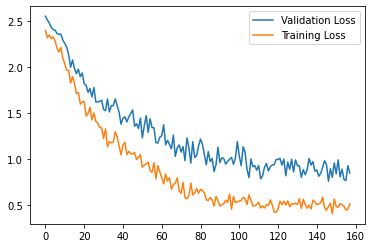

In [ ]:
plot_losses(cfg)

In [ ]:
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator

# evaluator = COCOEvaluator("kitti_mots_test", cfg, False, output_dir="output")

In [ ]:
# trainer.test(cfg, trainer.model, evaluators=[evaluator])
# plot_losses(cfg)

predictor = DefaultPredictor(cfg)
predictor.model.load_state_dict(trainer.model.state_dict())

<All keys matched successfully>

In [ ]:
dataset_dicts = get_kiti_mots_dicts("/content/drive/MyDrive/KITTI MOTS/training/image_02", "/content/drive/MyDrive/KITTI MOTS/training/instances_txt", is_train=False, image_extension='png')

/content/drive/MyDrive/KITTI MOTS/training/instances_txt/0015.txt
/content/drive/MyDrive/KITTI MOTS/training/instances_txt/0016.txt
/content/drive/MyDrive/KITTI MOTS/training/instances_txt/0017.txt
/content/drive/MyDrive/KITTI MOTS/training/instances_txt/0018.txt
/content/drive/MyDrive/KITTI MOTS/training/instances_txt/0019.txt
/content/drive/MyDrive/KITTI MOTS/training/instances_txt/0020.txt


In [ ]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4

/usr/local/lib/python3.7/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:154: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


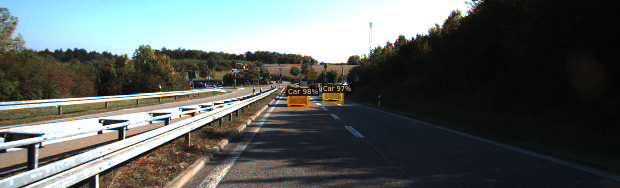

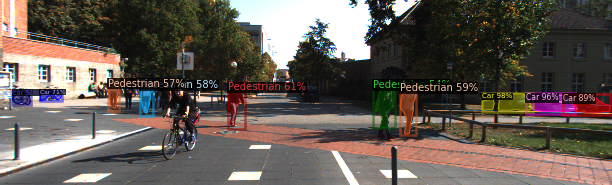

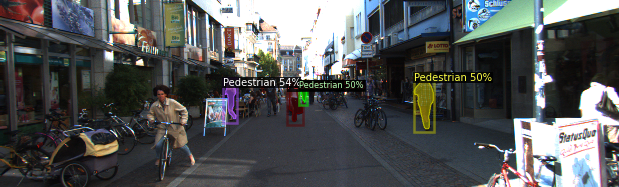

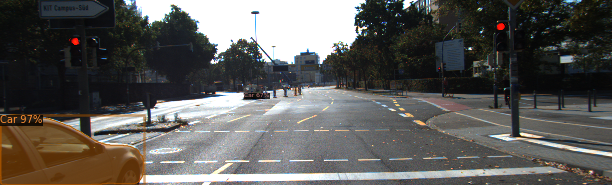

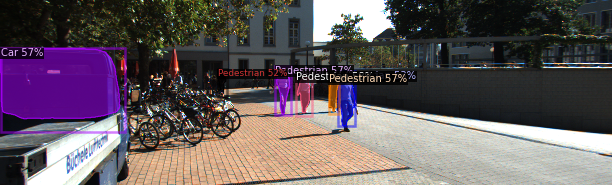

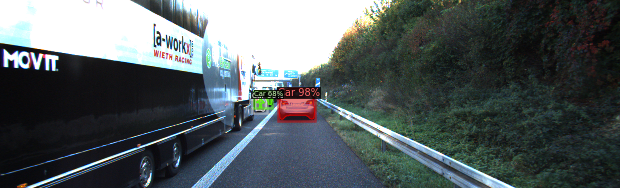

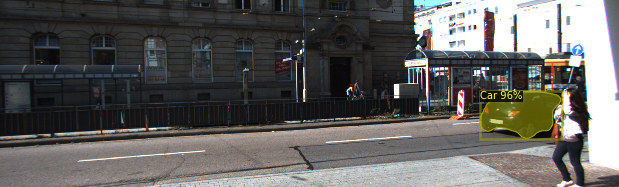

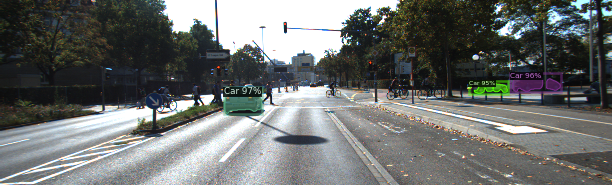

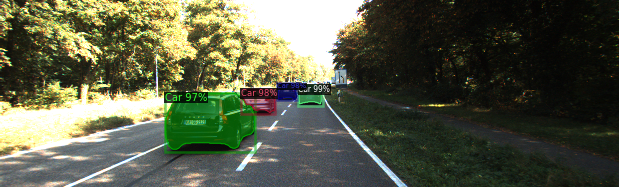

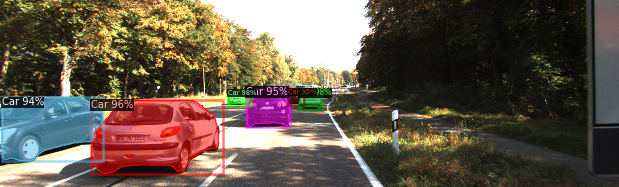

In [ ]:
show_results(cfg, dataset_dicts, predictor, samples=10)

# Tracking

## Tracking in pairs of frames

Getting predictions for all frames:

In [ ]:
output_dict = {}

for i in range(len(dataset_dicts)):
    data = dataset_dicts[i]
    im = cv2.imread(data["file_name"])
    outputs = predictor(im)

    # img_name = data["file_name"].split('/')[-1]
    # img_subname = img_name.split('.')[0]

    output_dict[i] = outputs

In [ ]:
output_dict.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

Matching objects in a pair of frames:

In [ ]:
from detectron2.structures import pairwise_iou # used for box overlap

def pairwise_matcher(pred_a, pred_b):

    boxes_a = pred_a.pred_boxes
    boxes_b = pred_b.pred_boxes

    pred_a_cls= pred_a.pred_classes
    pred_b_cls = pred_b.pred_classes

    pred_classes = torch.ones(pred_a_cls.shape[0], pred_b_cls.shape[0], device='cuda')
    temp = pred_classes * pred_b.pred_classes

    for col in range(len(temp[0])):
        temp[:, col] = (temp[:, col] == pred_a_cls)

    
    matching_class = pairwise_iou(boxes_a, boxes_b)*temp

    max_vals, best_match = torch.max(matching_class, axis=1)
    best_match[max_vals==0] = -1 # no match

    return best_match

In [ ]:
best_match = pairwise_matcher(output_dict[0]["instances"], output_dict[1]["instances"])

In [ ]:
best_match

tensor([0], device='cuda:0')

In [ ]:
tracking_list = []
for idx in range(0, len(output_dict)-1):
    pairwise_track = pairwise_matcher(output_dict[idx]["instances"], output_dict[1+idx]["instances"])
    tracking_list.append(pairwise_track)

In [ ]:
def generate_colors(num_boxes):
  box_colors = []
  r, g, b = 158, 39, 248
  step = 256 / num_boxes
  for i in range(num_boxes):
    r += step
    g += step
    b += step
    r = int(r) % 256
    g = int(g) % 256
    b = int(b) % 256
    box_colors.append((r/255, g/255, b/255)) 
  return box_colors

## Tracking in videos

### Without tracking:

In [ ]:
for idx in range(15000000, 15000000+len(output_dict)-1):
    i = idx - 15000000
    im = cv2.imread(dataset_dicts[i]['file_name'])

    v = Visualizer(
        im[:, :, ::-1], MetadataCatalog.get("kitti_mots_test"), scale=0.5)
    v = v.draw_instance_predictions(output_dict[idx]["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])
    cv2.waitKey(0)

### Tracking:

In [ ]:
present_pred_classes = output_dict[0]["instances"].pred_classes
present_colors = generate_colors(len(present_pred_classes))

class_names = ["track"+str(i) for i in range(len(present_pred_classes))]
global_class_name_counter = len(class_names)
tracked_output = []
start_frame = 0
num_frames = 444
os.makedirs(os.path.join(cfg.OUTPUT_DIR,'tracked_frames'), exist_ok=True)

In [ ]:
for idx in range(start_frame, start_frame+num_frames):
      img = cv2.imread(dataset_dicts[idx]['file_name'])
      v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)

      for cidx, bbox in enumerate(output_dict[idx]["instances"].pred_boxes.tensor):
          text_pos = (bbox[0].cpu(), bbox[1].cpu())
          v.draw_box(bbox.cpu(), edge_color=present_colors[cidx], alpha=0.9)
          v.draw_text(class_names[cidx], 
                      text_pos, 
                      color=present_colors[cidx], 
                      font_size=10)

      img = v.get_output().get_image()[:, :, ::-1]

      img_name = str(idx)+'.jpg' if len(str(idx)) == 2 else '0'+str(idx)+'.jpg'
      final_pth = os.path.join('./tracked_frames/', img_name)
      cv2.imwrite(final_pth, img)
      tracked_output.append(img)

      if idx < (num_frames - 1):
          present_pred_classes = output_dict[idx+1]["instances"].pred_classes
          present_colors = generate_colors(len(present_pred_classes))
          new_class_names = [""] * (len(present_pred_classes))
          for idx, track_idx in enumerate(tracking_list[idx]):
              if track_idx != -1:
                  new_class_names[track_idx] = class_names[idx]
          for i, name in enumerate(new_class_names):
              if name=="":
                  new_class_names[i]="track"+str(global_class_name_counter)
                  global_class_name_counter+=1
          class_names=new_class_names

In [ ]:
from PIL import Image

In [ ]:
i = 0
for image in tracked_output:
    # cv2_imshow(image)
    img = Image.fromarray(image)
    image_name = i
    img.save(os.path.join(os.path.join(cfg.OUTPUT_DIR,'tracked_frames'), str(image_name)+".jpg"))
    i+=1

## Converting to video